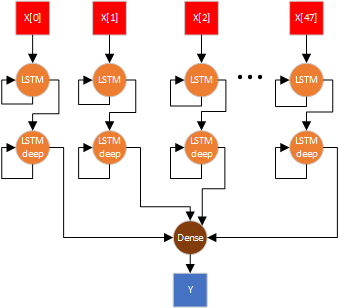
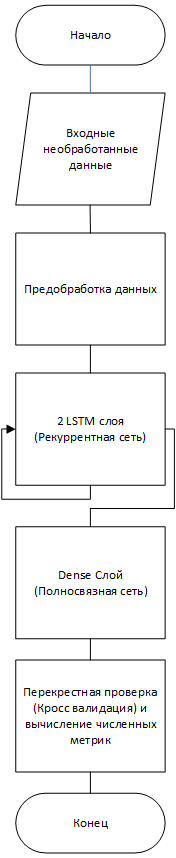

In [ ]:
pip install keras_metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy
import gc
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
import socket, struct
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler
from sklearn.model_selection import KFold
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time
import keras_metrics as km
from keras.layers import merge, Input, Dropout, Concatenate,Activation
from keras.models import Model


В коллекцию data записываются все датасеты подряд, удаляется 48 столбец с названием атаки, вычисляется их длина

In [ ]:
samplesCount = 0
data = []

for i in range(1,5):
    addblob = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UNSW-NB15_' + str(i) + '.csv', header=None)
    addblob = numpy.asarray(addblob)
    addblob = numpy.delete(addblob, 47, 1)
    samplesCount += len(addblob)
    data.extend(addblob)
del addblob
gc.collect()
print("Number of samples: " + str(len(data)))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of samples: 2540047


Заводится модель нейросети. 

In [ ]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback   




def getModel(neurons, layers, inputshape, batchsize):
  #Модель представляет собой последовательную нейросеть где каждый входной слой соединен с выходным
    model = Sequential()
    #инициализация входного ЛСТМ слоя
    model.add(LSTM(neurons, batch_input_shape = (batchsize, inputshape[0], inputshape[1]), return_sequences=True, stateful=True))
    for i in range(layers): #Для каждого слоя добавляем модель LSTM нейронов
        model.add(LSTM(neurons, return_sequences=True, stateful=True))  
    model.add(Dense(1,activation = 'sigmoid')) #выходной полносвязный слой сети
    model.compile(optimizer="adam", 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    

In [ ]:
def iptoint(ip):
    return struct.unpack("!I",(socket.inet_aton(ip)))[0] 

def parse(data):
    protocols = dict()
    protocolsNum = 1
    services  = dict()
    servicesNum = 1
    states = dict()
    statesNum = 1
    numMalicious = 0
    numNormal = 0
    x = []
    y = []
    for dataRaw in data:
        dataRaw[0] = iptoint(dataRaw[0]) #1 srcip nominal Source IP address
        dataRaw[2] = iptoint(dataRaw[2]) #3 dstip nominal Destination IP address
        #Source IP
        if (type(dataRaw[39]) == str):  #40 ct_ftp_cmd integer No of flows that has a command in ftp session.
            if (dataRaw[39] !=  " "):
                dataRaw[39] = int(dataRaw[39],0)
            else:
                dataRaw[39] = 0
        if (type(dataRaw[1]) == str): #2 sport integer Source port number
            if (dataRaw[1] != "-"):
                dataRaw[1] = int(dataRaw[1],0)
            else:
                dataRaw[1] = 0
        #Dest IP
        if (type(dataRaw[3]) == str): #4 dsport integer Destination port numbe
            if (dataRaw[3] != "-"):
                dataRaw[3] = int(dataRaw[3],0)
            else:
                dataRaw[3] = 0
        if (dataRaw[4] in protocols): #5 proto nominal Transaction protocol
            dataRaw[4] = protocols.get(dataRaw[4])
        else:
            protocols.update({dataRaw[4]:protocolsNum})
            dataRaw[4] = protocolsNum
            protocolsNum += 1

        if (type(dataRaw[4])!= int):
            print (dataRaw[4])
 
        if (dataRaw[5] in states):
            dataRaw[5] = states.get(dataRaw[5]) #6 state nominal Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR,...
        else:
            states.update({dataRaw[5]:statesNum})
            dataRaw[5] = statesNum
            statesNum += 1
        if (type(dataRaw[5])!=int):
            print (dataRaw[5])
        if (dataRaw[13] in services):
            dataRaw[13] = services.get(dataRaw[13]) #14 service nominal http, ftp, smtp, ssh, dns, ftp-data ,irc and (-) if not much used service
        else:
            services.update({dataRaw[13]:servicesNum})
            dataRaw[13] = servicesNum
            servicesNum += 1
        if (type(dataRaw[13])!=int):
            print (dataRaw[13])
        if (dataRaw[47] == 1): #48 attack_cat nominal The name of each attack category. In this data set , nine categories e.g. Fuzzers, Analysis, Backdoo...
            numMalicious = numMalicious + 1
            y.append(1)
        else:
            numNormal = numNormal + 1
            y.append(0)
        i = 0
        for data in dataRaw:
            if (type(data) == str):
                print(dataRaw,data,i)
            i = i+1
        x.append(dataRaw)
    #Выше тернарным оператором собираем информацию о датасете и количестве признаков
    print("normal = ",numNormal)
    print("Malicious = ", numMalicious)
    print(protocols)
    print(states)
    print(services)
    return [x, y]

#Функция кросс-валидации для оценки поведения модели
def CrossValidation(lenOfBlock , X, Y, neurons, layers, inputshape, epochsIn, batchsize):
    cv = KFold(n_splits = lenOfBlock, random_state = None, shuffle = False)
    #параметры для кросс валидации
    TN = 0 
    FP = 0
    FN = 0
    TP = 0
    F1 = 0
    Educate = 0.0
    Test = 0.0
    print("Neurons: ", neurons)
    print("Layers: ", layers)
    numblock=0
    for train_index, test_index in cv.split(X):
        gc.collect()
        clf = getModel(neurons, layers, inputshape, batchsize)
        print("TRAIN:", train_index, "TEST:", test_index)
        print("Block: ", numblock)
        numblock +=1
        start_time = time.time()
        for i in range (epochsIn):
            history = clf.fit(X[train_index], Y[train_index], epochs = 1, validation_data = (X[test_index],Y[test_index]), batch_size = batchsize, shuffle = False)
        education_time = time.time() - start_time
        try:
            # Тестирование
            start_time = time.time()
            proba = numpy.round(numpy.asarray(clf.predict(X[test_index], batch_size = batchsize)))

            test_time = time.time() - start_time

            # Добавляем значения
            Educate += education_time
            Test += test_time
            y = Y[test_index].flatten()
            proba = proba.flatten()
            cn = confusion_matrix(y, proba, labels=[0,1])
            print(cn)
            tn, fp, fn, tp = cn.ravel()
        except ZeroDivisionError:
            print("ZeroDivisionError")
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        F1 += (f1_score(y, proba , average='binary', zero_division = 1))
        
    summ = TN + FP + FN + TP
    
    print("\n\n\n")
    print("Block len " + str(lenOfBlock))
    print("True positive " + str(TP / summ), TP)
    print("True negative " + str(TN / summ), TN)
    print("False positive " + str(FP / summ), FP)
    print("False negative " + str(FN / summ), FN)
   
    print("Accuracy " + str((TP + TN)/(summ)))
    print("Precision " + str(TP / (TP + FP))) # Precision
    print("Recall " + str(TP / (TP + FN))) # Recall

    print("F1 score " + str(F1 / lenOfBlock)) # F1 score
    print("Educate time " + str(Educate / lenOfBlock)) # Educate time
    print("Test time " + str(Test / lenOfBlock)) # Test time

    print("\n\n\n")    
 

In [ ]:

[x, y] = parse(data) #датасет в двумерный массив
del data
gc.collect()

x = numpy.reshape(x,(2540047, 48)) # x - привидение в форму массива
y = numpy.reshape(y,(2540047)) # y - список признаков

newx = numpy.delete(numpy.asarray(x), 47, 1) #newx - массив данных без информации о типе атаки

newx = newx.tolist() #получение вложенных массивов
newy = y.tolist()
del x,y
gc.collect()


normal =  2218764
Malicious =  321283
{'udp': 1, 'arp': 2, 'tcp': 3, 'ospf': 4, 'icmp': 5, 'igmp': 6, 'sctp': 7, 'udt': 8, 'sep': 9, 'sun-nd': 10, 'swipe': 11, 'mobile': 12, 'pim': 13, 'rtp': 14, 'ipnip': 15, 'ip': 16, 'ggp': 17, 'st2': 18, 'egp': 19, 'cbt': 20, 'emcon': 21, 'nvp': 22, 'igp': 23, 'xnet': 24, 'argus': 25, 'bbn-rcc': 26, 'chaos': 27, 'pup': 28, 'hmp': 29, 'mux': 30, 'dcn': 31, 'prm': 32, 'trunk-1': 33, 'xns-idp': 34, 'trunk-2': 35, 'leaf-1': 36, 'leaf-2': 37, 'irtp': 38, 'rdp': 39, 'iso-tp4': 40, 'netblt': 41, 'mfe-nsp': 42, 'merit-inp': 43, '3pc': 44, 'xtp': 45, 'idpr': 46, 'tp++': 47, 'ddp': 48, 'idpr-cmtp': 49, 'ipv6': 50, 'il': 51, 'idrp': 52, 'ipv6-frag': 53, 'sdrp': 54, 'ipv6-route': 55, 'gre': 56, 'rsvp': 57, 'mhrp': 58, 'bna': 59, 'esp': 60, 'i-nlsp': 61, 'narp': 62, 'ipv6-no': 63, 'tlsp': 64, 'skip': 65, 'ipv6-opts': 66, 'any': 67, 'cftp': 68, 'sat-expak': 69, 'kryptolan': 70, 'rvd': 71, 'ippc': 72, 'sat-mon': 73, 'ipcv': 74, 'visa': 75, 'cpnx': 76, 'cphb': 77, 

0

In [ ]:
while (len(newx)!=2540000): #приводим массивы к одинаковым значениям, pop() - удаляет и возвращает последнее значение массива
    newx.pop()
    newy.pop()

In [ ]:
print (newx[0]) #возвращает первый вложенный массив в newx
print (len(newx[0])) #возвращает длину перваого вложенного массива в newx
print (len(newx)) #возвращает длину newx
#Преобразуйте объекты, масштабируя каждый объект до заданного диапазона.
#Этот оценщик масштабирует и преобразует каждую функцию индивидуально так, чтобы она находилась в заданном диапазоне обучающего набора, например, между нулем и единицей.
#Преобразование производится:
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + mi
min_max_scaler = MinMaxScaler() 
newx = min_max_scaler.fit_transform(newx)
print(newx[0])
xnew= numpy.reshape(newx, (len(newx)//5, 5, 47))
print(len(newy))
ynew = numpy.reshape(newy,(len(newx)//5, 5,1))
print(xnew[0][0])
del newx,newy
gc.collect()
#nan заменены единицей
for i in range(len(xnew)):
    for j in range(len(xnew[i])):
        for k in range(len(xnew[i][j])):
            if numpy.isnan(xnew[i][j][k]):
                xnew[i][j][k] = 1


[1000734720, 1390, 2511044102, 53, 1, 1, 0.0010550000000000002, 132, 164, 31, 29, 0, 0, 1, 500473.9375, 621800.9375, 2, 2, 0, 0, 0, 0, 66, 82, 0, 0, 0.0, 0.0, 1421927414, 1421927414, 0.017, 0.013000000000000001, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 3, 7, 1, 3, 1, 1, 1]
47
2540000
[2.71179403e-01 2.12100404e-02 6.52407146e-01 9.83321850e-08
 0.00000000e+00 0.00000000e+00 1.20068681e-07 9.19490652e-06
 1.11887875e-05 1.21568627e-01 1.14173228e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.35794783e-05 4.82907536e-03
 1.87863986e-04 1.81521147e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.38829787e-02 5.46666667e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.58479216e-05 0.00000000e+00 2.01489849e-07 2.18541314e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.03030303e-02 9.09090909e-02 0.00000000e+00 3.03030303e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2540000


    CrossValidation(lenOfBlock , X, Y, neurons, layers, inputshape, epochsIn, batchsize):
    print("Neurons: ", neurons)
    print("Layers: ", layers)
    print("TRAIN:", train_index, "TEST:", test_index)
    print("Block: ", numblock)
    print(cn) cn = confusion_matrix(y, proba, labels=[0,1])
    print("ZeroDivisionError")

    print("Block len " + str(lenOfBlock))
    print("True positive " + str(TP / summ), TP)
    print("True negative " + str(TN / summ), TN)
    print("False positive " + str(FP / summ), FP)
    print("False negative " + str(FN / summ), FN)
  
    print("Accuracy " + str((TP + TN)/(summ)))
    print("Precision " + str(TP / (TP + FP))) # Precision
    print("Recall " + str(TP / (TP + FN))) # Recall

    print("F1 score " + str(F1 / lenOfBlock)) # F1 score
    print("Educate time " + str(Educate / lenOfBlock)) # Educate time
    print("Test time " + str(Test / lenOfBlock)) # Test time

    clf = getModel(neurons, layers, inputshape, batchsize)
    history = clf.fit(X[train_index],
                      Y[train_index], 
                      epochs = 1, 
                      validation_data = (X[test_index],Y[test_index]), 
                      batch_size = batchsize, shuffle = False)

    true negative is C_{0,0} false negatives is C_{1,0}, 
    false positives is C_{0,1} true positives is C_{1,1}

In [ ]:
CrossValidation(10 , xnew , ynew, 100, 1, (5,47), 3, 50)

Neurons:  100
Layers:  1
TRAIN: [ 50800  50801  50802 ... 507997 507998 507999] TEST: [    0     1     2 ... 50797 50798 50799]
Block:  0
9144/9144 [==============================] - 119s 13ms/step - loss: 0.0174 - accuracy: 0.9922 - val_loss: 0.0291 - val_accuracy: 0.9874
[[229435   2350]
 [   854  21361]]
TRAIN: [     0      1      2 ... 507997 507998 507999] TEST: [ 50800  50801  50802 ... 101597 101598 101599]
Block:  1
9144/9144 [==============================] - 119s 13ms/step - loss: 0.0198 - accuracy: 0.9910 - val_loss: 2.1378e-04 - val_accuracy: 1.0000
[[253991      9]
 [     0      0]]
TRAIN: [     0      1      2 ... 507997 507998 507999] TEST: [101600 101601 101602 ... 152397 152398 152399]
Block:  2
9144/9144 [==============================] - 133s 15ms/step - loss: 0.0202 - accuracy: 0.9910 - val_loss: 4.8021e-05 - val_accuracy: 1.0000
[[254000      0]
 [     0      0]]
TRAIN: [     0      1      2 ... 507997 507998 507999] TEST: [152400 152401 152402 ... 203197 203198 20